# scVelo analysis

## Preparation

In [1]:
#Library
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd 
import numpy as np
import scanpy as sc
import warnings

In [2]:
adata = sc.read_h5ad("../02_Input_merge_and_filteration/merged_Pik.h5ad")

In [3]:
print(adata.obs[["umap_1", "umap_2"]].head())

                                                umap_1    umap_2
CellID                                                          
possorted_genome_bam_F2ZHW:AAAGGGCTCTGTCAGAx  2.844351  3.001735
possorted_genome_bam_F2ZHW:AAAGTCCAGTGCTCGCx  1.854609 -7.134219
possorted_genome_bam_F2ZHW:AAAGAACTCTAAACGCx -7.574637 -7.710628
possorted_genome_bam_F2ZHW:AAACGAATCAAGTGGGx  7.519389  6.254953
possorted_genome_bam_F2ZHW:AAAGTCCGTACGAGTGx  8.172050  6.475503


In [4]:
# Copy into obsm
adata.obsm["X_umap"] = adata.obs[["umap_1", "umap_2"]].to_numpy()
print(adata.obsm["X_umap"][:5])

[[ 2.84435093  3.00173548]
 [ 1.85460854 -7.13421866]
 [-7.57463706 -7.710628  ]
 [ 7.51938903  6.25495342]
 [ 8.17204988  6.475503  ]]


In [5]:
# Clean-up
adata.obs = adata.obs.drop(columns=["umap_1", "umap_2"])

In [6]:
# Add PCA info

# Load PCA coordinates
pca_df = pd.read_csv("X_pca.csv", index_col=0)

In [7]:
print(len(pca_df), "rows in PCA file")
print(len(adata), "cells in adata")

15933 rows in PCA file
16043 cells in adata


In [8]:
overlap = pca_df.index.intersection(adata.obs_names)
print(len(overlap), "IDs overlap")

15933 IDs overlap


In [9]:
# cells present in both, preserving adata's order
common = adata.obs_names[adata.obs_names.isin(pca_df.index)]

In [10]:
# subset and embed
adata_sub = adata[common].copy()
adata_sub.obsm["X_pca"] = pca_df.loc[common].to_numpy()

In [11]:
print(adata_sub.shape, adata_sub.obsm["X_pca"].shape)

(15933, 32285) (15933, 50)


In [12]:
adata_sub

AnnData object with n_obs × n_vars = 15933 × 32285
    obs: 'cell_type', 'sample'
    obsm: 'X_umap', 'X_pca'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [13]:
print(adata_sub.obs["cell_type"].unique())

['LC_ER-_LuP', 'LC_ER+_Foxa1', 'Myo', 'LC_ER-_LaP', 'LC_ER+_Sca1', 'Late_HY', 'Early_HY']
Categories (7, object): ['Early_HY', 'LC_ER+_Foxa1', 'LC_ER+_Sca1', 'LC_ER-_LaP', 'LC_ER-_LuP', 'Late_HY', 'Myo']


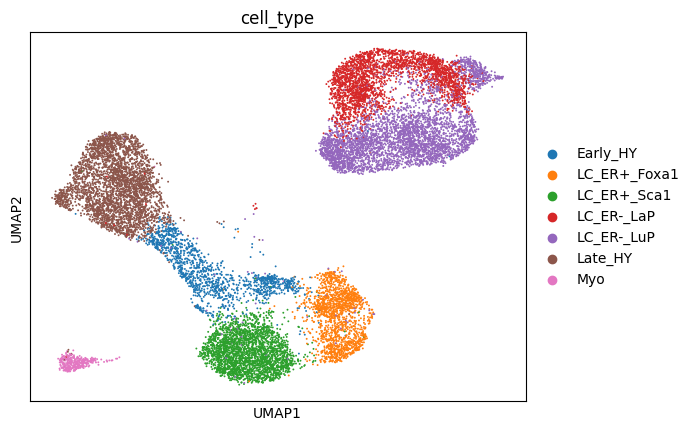

In [14]:
sc.pl.umap(adata_sub, color='cell_type')

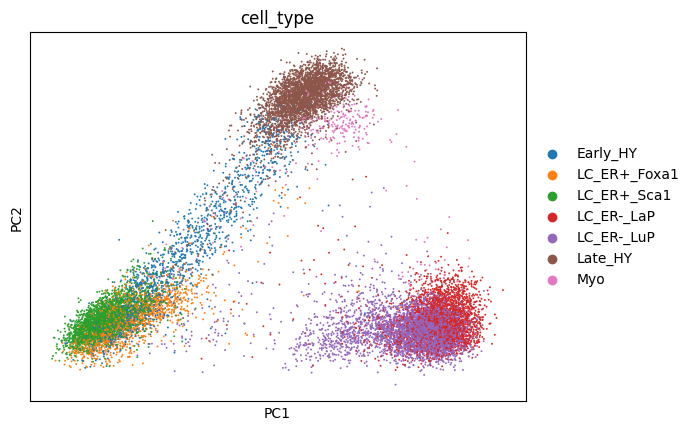

In [15]:
sc.pl.pca(adata_sub, color='cell_type')

In [16]:
print(adata_sub.obs["sample"].unique())

['CTL', 'ER_Pik', 'Kit_Pik']
Categories (3, object): ['CTL', 'ER_Pik', 'Kit_Pik']


In [17]:
# Filteration of specific sample
adata_sub = adata_sub[adata_sub.obs["sample"] == "CTL"].copy()

In [18]:
print(adata_sub.obs["sample"].unique())

['CTL']
Categories (1, object): ['CTL']


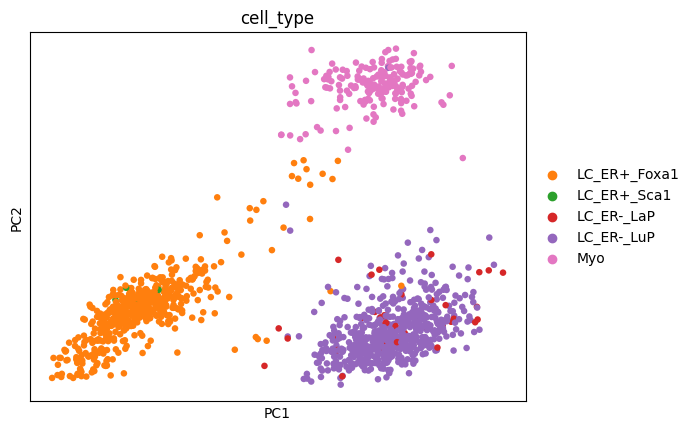

In [19]:
sc.pl.pca(adata_sub, color='cell_type')

## Preprocessing

In [20]:
scv.pp.filter_and_normalize(adata_sub)
scv.pp.moments(adata_sub)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [21]:
scv.tl.velocity(adata_sub, mode='stochastic')
scv.tl.velocity_graph(adata_sub)

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1352 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


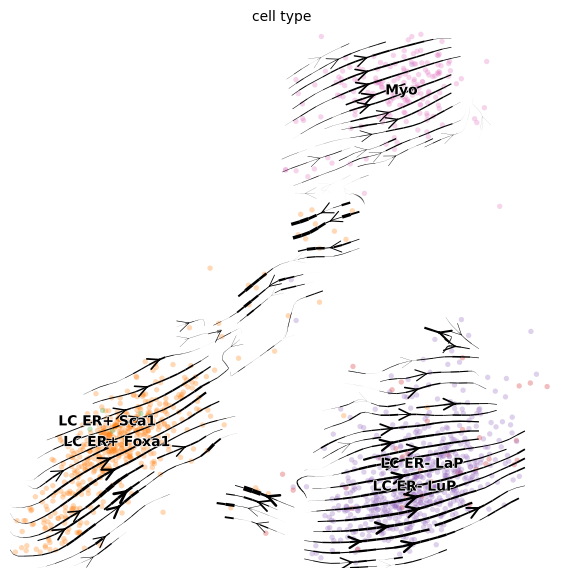

In [24]:
scv.pl.velocity_embedding_stream(adata_sub, basis='pca',color='cell_type', 
                                 figsize=(7,7), size=60, linewidth=2, arrow_size=2, arrow_style='->')

saving figure to file ./figures/scvelo_scVelo_stream_without_Prolif-PCA_CTL.png


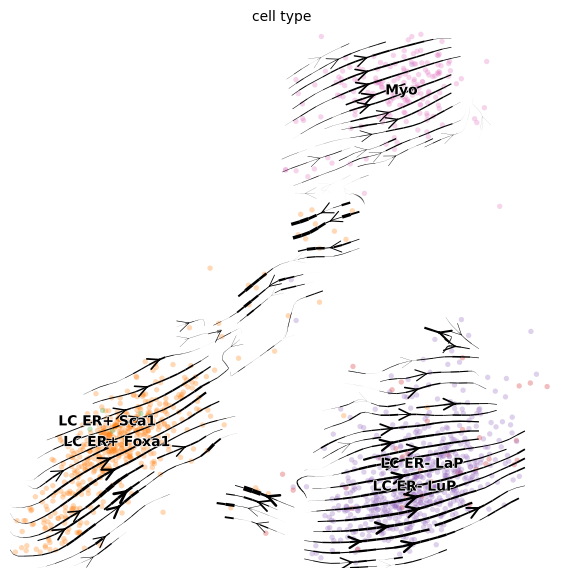

In [25]:
scv.pl.velocity_embedding_stream(adata_sub, basis='pca',color='cell_type', 
                                 figsize=(7,7), size=60, linewidth=2, arrow_size=2, arrow_style='->', save="scVelo_stream_without_Prolif-PCA_CTL.png")

## PAGA Graph Plotting

In [26]:
# groups exist and are non-empty?
print(adata_sub.obs['cell_type'].unique())
print((adata_sub.obs['cell_type'] == 'LC_ER+_Sca1').sum(),
      (adata_sub.obs['cell_type'] == 'Myo').sum())

# neighbors graph exists?
print('neighbors' in adata_sub.uns,
      adata_sub.uns.get('neighbors', {}).keys() if 'neighbors' in adata_sub.uns else None)

# velocity graph exists?
print('velocity_graph' in adata_sub.uns, 'velocity_graph_neg' in adata_sub.uns)

['LC_ER-_LuP', 'LC_ER+_Foxa1', 'Myo', 'LC_ER-_LaP', 'LC_ER+_Sca1']
Categories (5, object): ['LC_ER+_Foxa1', 'LC_ER+_Sca1', 'LC_ER-_LaP', 'LC_ER-_LuP', 'Myo']
4 186
True dict_keys(['connectivities_key', 'distances_key', 'indices', 'params'])
True True


In [27]:
root_cells = adata_sub.obs_names[adata_sub.obs['cell_type'] == 'LC_ER+_Sca1']
end_cells  = adata_sub.obs_names[adata_sub.obs['cell_type'] == 'Myo']

In [28]:
scv.tl.paga(adata_sub, groups='cell_type', root_key="LC_ER+_Sca1", end_key="Myo", use_time_prior=False)

running PAGA 
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


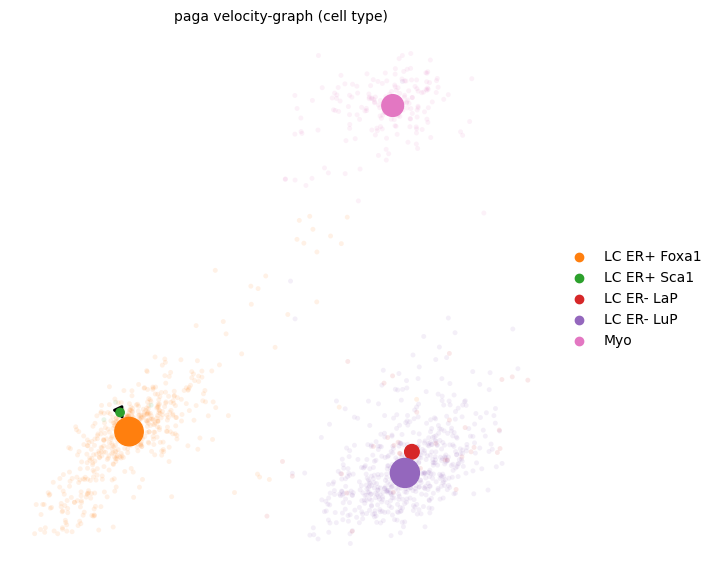

In [29]:
scv.pl.paga(adata_sub, basis='pca', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5, figsize=(7,7))

computing terminal states
    identified 2 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
saving figure to file ./figures/scvelo_velocity_pseudotime_pca_CTL.pdf


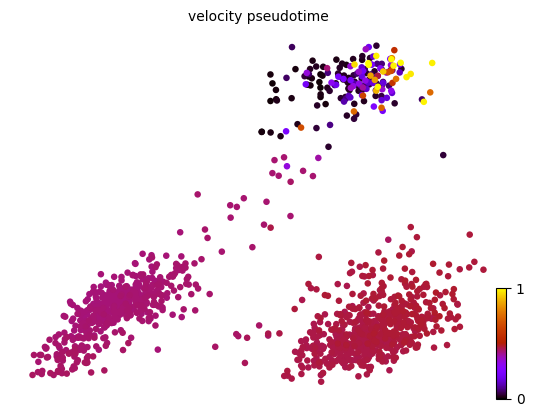

In [30]:
scv.tl.velocity_pseudotime(adata_sub)
scv.pl.scatter(adata_sub, color='velocity_pseudotime', color_map='gnuplot', basis="pca", save="velocity_pseudotime_pca_CTL.pdf")

In [31]:
#adata_sub.write("scVelo_PCA-embed.h5ad")

## Formatting

In [32]:
celltype_colors = {   
    "LC_ER+_Sca1": "#800000",       
    "LC_ER+_Foxa1": "#F08080",
    "LC_ER-_LuP": "#FFA500", 
    "LC_ER-_LaP": "#2F4F4F",
    "Myo": "#1E90FF"
}

# Apply colors to AnnData object
adata_sub.uns["cell_type_colors"] = [
    celltype_colors[ct] for ct in adata_sub.obs["cell_type"].cat.categories
]

saving figure to file ./figures/scvelo_scVelo_stream_without_Prolif_PAGA-PCA_CTL.pdf


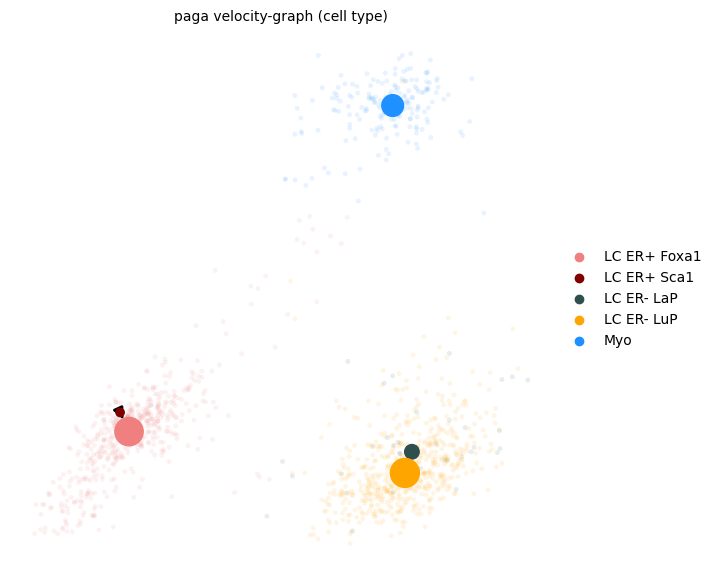

In [33]:
# Formatting of plots

scv.pl.paga(adata_sub, basis='pca', size=50, alpha=.1,  groups="cell_type",
            min_edge_width=2, node_size_scale=1.5, figsize=(7,7), save='scVelo_stream_without_Prolif_PAGA-PCA_CTL.pdf')

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_scVelo_stream_without_Prolif-PCA_ERPik.CTL.png


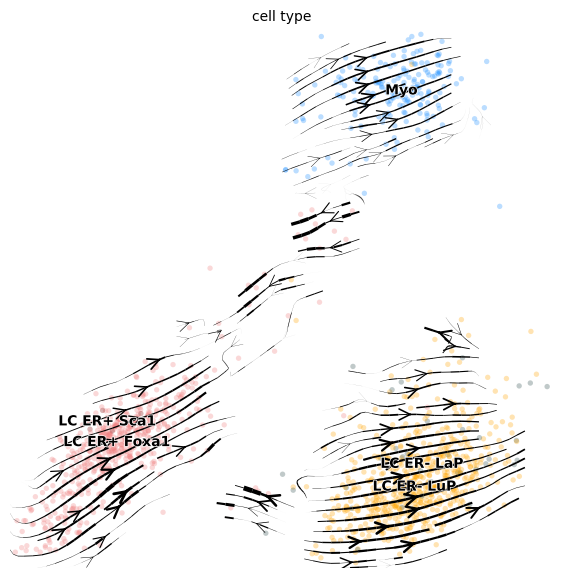

In [34]:
scv.pl.velocity_embedding_stream(adata_sub, basis='pca',color='cell_type', 
                                 figsize=(7,7), size=60, linewidth=2, arrow_size=2, arrow_style='->', save="scVelo_stream_without_Prolif-PCA_ERPik.CTL")

In [35]:
from matplotlib.collections import LineCollection   # <-- needed

# 1) Remove cells with any NaN/Inf in PCA or velocity
mask = np.isfinite(adata_sub.obsm['X_pca']).all(axis=1)
if 'velocity_pca' in adata_sub.obsm:
    mask &= np.isfinite(adata_sub.obsm['velocity_pca']).all(axis=1)
if 'cell_type' in adata_sub.obs:
    mask &= adata_sub.obs['cell_type'].notna().values

adata_ok = adata_sub[mask].copy()

# 2) Plot without displaying
ax = scv.pl.velocity_embedding_stream(
    adata_ok,
    basis="pca",
    color="cell_type",
    figsize=(7,7),
    size=60,
    linewidth=2,
    arrow_size=2,
    arrow_style="->",
    show=False
)

# 3) Rasterize heavy streamline collections to keep PDF clean
for coll in ax.collections:
    if isinstance(coll, LineCollection):
        coll.set_rasterized(True)

# 4) Save as vector PDF
fig = ax.get_figure()
fig.savefig("scVelo_stream_without_Prolif-PCA_CTL.pdf",
            bbox_inches="tight", dpi=300)
plt.close(fig)